In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
filename = '/content/drive/My Drive/annotedData.csv'
data = pd.read_csv(filename)
file = open(filename, 'r')
raw_text = file.read()
file.close()

In [3]:
def to_Int(x):
    s = 0
    for i in x:
        if(i >= '0' and i <= '9'):
            s *= 10
            s += int(i)
    return s


In [4]:
data.dropna(inplace = True)

data = data[:int(99*len(data)/100)]

data.Sent = data.Sent.apply(to_Int)

data.tail()

,Sent,Word,Tag
71417,3602,0,Other
71418,3602,Obama,B-Per
71419,3602,ne,Other
71420,3602,kath,Other
71421,3602,ke,Other


In [5]:
#Generates a list of tuples of (tweets, character wise classification whether the character is in an NER or not)

inp_tweets = []

val = 0
j = 0
for val in range(1521):
    s1 = ""
    s2 = ""
    while(int(data['Sent'].iloc[j]) == val):
        s1 += str((data['Word']).iloc[j])
        s1 += " "
        if(str(data['Tag'].iloc[j]) == 'Other'):
            c = '0'
        else:
            c = '1'
        for y in range(len(data['Word'].iloc[j])):
            s2 += c
        s2 += '0'
        j += 1
    assert(len(s1) == len(s2))
    if(s1 != ''):
        inp_tweets.append([s1, s2])

inp_tweets[0]

['Bahubali 2 ke liye line lag sakte hai desh ke liye kyun lage line me ... #notebandi #Bahubali2 ',
 '11111111000000000000000000000000000000111100000000000000000000000000000000000000000011111111110']

In [6]:
#Test-Train split 80-20

EIGHTY_TWENTY = int(80/100 * len(inp_tweets))
train = inp_tweets[:EIGHTY_TWENTY]
test = inp_tweets[EIGHTY_TWENTY:]

The longest tweet is of length 312


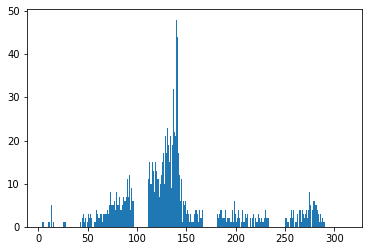

In [7]:
#Distribution of lengths of tweets in characters
cnts = {}
MAX_TWEET_LEN = 0
for i in range(len(inp_tweets)):
    if(len(inp_tweets[i][0]) not in cnts):
        cnts[len(inp_tweets[i][0])] = 1
    else:
        cnts[len(inp_tweets[i][0])] += 1
    MAX_TWEET_LEN = max(MAX_TWEET_LEN, len(inp_tweets[i][0]))
plt.bar(cnts.keys(), cnts.values())
print(f'The longest tweet is of length {MAX_TWEET_LEN}')

In [8]:
#Making a mapping of characters for one-hot encoding
char_list = ['^'] + sorted(set(raw_text))
mapping = dict((c, i) for i, c in enumerate(char_list))
N_CHARS = len(char_list)
print(f'The number of distinct characters in the dataset are {N_CHARS}')

The number of distinct characters in the dataset are 111


In [9]:
x_train = [x[0] for x in train]
y_train = [x[1] for x in train]
x_test = [x[0] for x in test]
y_test = [x[1] for x in test]

In [10]:
#Util functions to create tensors of one-hot encoding of characters

def letter_to_index(letter):
    return mapping[letter]

#Generates a 1xn tensor.
def letter_to_tensor(letter):
    tensor = torch.zeros(N_CHARS)
    tensor[letter_to_index(letter)] = 1
    return tensor

#Generates a line_lengthx1xn tensor
def line_to_tensor(line):
    tensor = torch.zeros(len(line), N_CHARS)
    for i, letter in enumerate(line):
        tensor[i][letter_to_index(letter)] = 1
    return tensor

def output_to_tensor(line):
  tensor = torch.zeros(len(line))
  for i, letter in enumerate(line):
    tensor[i] = int(letter)
  return tensor

In [11]:
#Pad all strings to max tweet length for RNN training

print(f'Tweet before padding {x_train[0]}')
print(f'Answer before padding {y_train[0]}\n')

for i in range(len(x_train)):
    x_train[i] = x_train[i].ljust(MAX_TWEET_LEN, '^')
    y_train[i] = y_train[i].ljust(MAX_TWEET_LEN, '0')

for i in range(len(x_test)):
    x_test[i] = x_test[i].ljust(MAX_TWEET_LEN, '^')
    y_test[i] = y_test[i].ljust(MAX_TWEET_LEN, '0')

print(f'Tweet after padding {x_train[0]}')
print(f'Answer after padding {y_train[0]}')


Tweet before padding Bahubali 2 ke liye line lag sakte hai desh ke liye kyun lage line me ... #notebandi #Bahubali2 
Answer before padding 11111111000000000000000000000000000000111100000000000000000000000000000000000000000011111111110

Tweet after padding Bahubali 2 ke liye line lag sakte hai desh ke liye kyun lage line me ... #notebandi #Bahubali2 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Answer after padding 111111110000000000000000000000000000001111000000000000000000000000000000000000000000111111111100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000


In [12]:
#Convert strings to list of one-hot encodings of characters
str_x_test = x_test.copy()

for i in range(len(x_train)):
    x_train[i] = line_to_tensor(x_train[i])
    y_train[i] = output_to_tensor(y_train[i])

for i in range(len(x_test)):
    x_test[i] = line_to_tensor(x_test[i])
    y_test[i] = output_to_tensor(y_test[i])

x_train[:2]
y_train[:2]

[tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,

In [13]:
#Convert lists to tensors
x_train = torch.stack(x_train)
y_train = torch.stack(y_train)

x_test = torch.stack(x_test)
y_test = torch.stack(y_test)

In [14]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

torch.Size([1044, 312, 111]) torch.Size([1044, 312]) torch.Size([261, 312, 111]) torch.Size([261, 312])


In [15]:
#Define bi-directional RNN module
class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(GRU, self).__init__()
    self.num_layers = num_layers
    self.hidden_size = hidden_size
    self.input_size = input_size
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)
    self.sigmoid = nn.Sigmoid()


  def forward(self, x):
    num_batches = x.shape[0]
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
    out, _ = self.gru(x, h0)
    #print(f'The shape of out tensor is: {out.shape}')
    out = self.fc(out)
    #print(f'The shape of out tensor is: {out.shape}')
    out = out.view(num_batches, -1)
    out = self.sigmoid(out)
    #print(f'The shape of out tensor is: {out.shape}')
    return out

In [17]:
#HYPER-PARAMETERS

loss_function = nn.BCELoss()
batch_size = 100
learning_rate = 0.002
num_epochs = 15

In [18]:
model = GRU(x_train.shape[2], 128, 1)
# input_tensor = line_to_tensor('Cat is named Kalyan')
# input_tensor = input_tensor.view(1, -1, N_CHARS)

# out_tensor = torch.zeros(1, 19)
# out = model(input_tensor)
# print(loss_function(out, out_tensor))

tensor(0.6814, grad_fn=<BinaryCrossEntropyBackward>)


In [19]:
train = [(x_train[i], y_train[i]) for i in range(len(x_train))]
test = [(x_test[i], y_test[i]) for i in range(len(x_test))]

In [20]:
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size, shuffle = True)

In [21]:
#Train
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
  loss_g = 0
  for i, (inp, out) in enumerate(train_loader):
    output = model(inp)
    loss = loss_function(output, out)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_g = loss
  print(f'Epoch #{epoch + 1}, Loss = {loss_g}')
    #if((i + 1) % 500):
      #print(f'Epoch #{epoch + 1}, iter #{i+1}, loss = {loss.item()}')

Epoch #1, Loss = 0.13128796219825745
Epoch #2, Loss = 0.1809779703617096
Epoch #3, Loss = 0.19665484130382538
Epoch #4, Loss = 0.14741702377796173
Epoch #5, Loss = 0.12225444614887238
Epoch #6, Loss = 0.12134065479040146
Epoch #7, Loss = 0.14713236689567566
Epoch #8, Loss = 0.10974237322807312
Epoch #9, Loss = 0.08696059137582779
Epoch #10, Loss = 0.1046481803059578
Epoch #11, Loss = 0.11624167859554291
Epoch #12, Loss = 0.09944627434015274
Epoch #13, Loss = 0.09815344959497452
Epoch #14, Loss = 0.08745590597391129
Epoch #15, Loss = 0.09374739229679108


In [22]:
punctuation = ['^', ' ', '.', ',', '!', '?']

def get_acc(s, orig, mod):
  match, mismatch = 0, 0
  curr_len = 0
  ner = True
  correct = True
  ner_correct, ner_wrong = 0, 0
  nner_correct, nner_wrong = 0, 0
  for i in range(len(s)):
    if(s[i] in punctuation):
      if(curr_len != 0):
        if(correct == True and ner == True):
          ner_correct += 1
        elif(correct == True and ner == False):
          nner_correct += 1
        elif(correct == False and ner == True):
          ner_wrong += 1
        else:
          nner_wrong += 1
      curr_len = 0
      correct = True
      
    else:
      if(orig[i] != mod[0][i].item()):
        correct = False
      curr_len += 1
      if(mod[0][i].item() == 0):
        ner = False
      else:
        ner = True
  return ner_correct, nner_correct, ner_wrong, nner_wrong
    

In [23]:
#Accuracy of words from test-set
with torch.no_grad():
  ner_correct, nner_correct, ner_wrong, nner_wrong = 0, 0, 0, 0
  for i in range(len(str_x_test)):
    tens = line_to_tensor(str_x_test[i]).view(1, -1, N_CHARS)
    tens = model(tens)
    tens = (tens >= 0.5).long()
    a, b, c, d = (get_acc(str_x_test[i], y_test[i], tens))
    ner_correct += a
    nner_correct += b
    ner_wrong += c
    nner_wrong += d


In [24]:
total = ner_correct + nner_correct + ner_wrong + nner_wrong

In [27]:
overall_accuracy = 100 * (0.0 + ner_correct + nner_correct) / total
nner_accuracy = 100 * (0.0 + nner_correct) / (nner_correct + nner_wrong)
ner_accuracy = 100 * (0.0 + ner_correct) / (ner_correct + ner_wrong)

In [28]:
print(f'The accuracy of the model on the test set is: {overall_accuracy:.2f}%')
print(f'The accuracy of the model on predicting Named Entities is: {ner_accuracy:.2f}%')
print(f'The accuracy of the model on predicting Non-Named Entities is: {nner_accuracy:.2f}%')


The accuracy of the model on the test set is: 92.88%
The accuracy of the model on predicting Named Entities is: 44.44%
The accuracy of the model on predicting Non-Named Entities is: 93.08%
